# Nigerian Fuel Subsidy Removal — Economic Impact Analysis
## Modelling Notebook

This notebook formally analyses the macroeconomic impact of Nigeria's May 2023 
fuel subsidy removal using regression modelling and structural break analysis.

**Research Questions:**
1. Did a statistically significant structural break occur at May 2023?
2. How much of the post-removal inflation surge can be attributed to fuel prices vs exchange rates?
3. Which factors consistently matter across different model types?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys
import os

# Add src to path
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from loader import load_all
from analysis import (engineer_features, get_model_data, train_all_models, 
                      evaluate_all_models, cross_validate_models, 
                      get_feature_importance, chow_test)

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
DATA_DIR = os.path.abspath(os.path.join('..', 'data', 'raw'))
df = load_all(DATA_DIR)
df_feat = engineer_features(df)

print(f"Dataset ready: {df_feat.shape[0]} months, {df_feat.shape[1]} columns")
df_feat[['date', 'inflation_all_items', 'fuel_price_ngn', 'fuel_lag1', 'fuel_roll3', 'post_subsidy_removal']].head(8)

Dataset ready: 74 months, 19 columns


,date,inflation_all_items,fuel_price_ngn,fuel_lag1,fuel_roll3,post_subsidy_removal
0,2020-01-01,12.13,145.00,NaN,NaN,0
1,2020-02-01,12.20,145.00,145.00,NaN,0
2,2020-03-01,12.26,145.00,145.00,145.00,0
3,2020-04-01,12.34,145.00,145.00,145.00,0
4,2020-05-01,12.40,145.00,145.00,145.00,0
5,2020-06-01,12.56,145.00,145.00,145.00,0
6,2020-07-01,12.82,145.00,145.00,145.00,0
7,2020-08-01,13.22,145.00,145.00,145.00,0


## Section 1 — Structural Break Analysis (Chow Test)

Before any modelling, we formally test whether the relationship between 
fuel prices, exchange rates and inflation changed significantly at May 2023.

A Chow test compares how well a single regression model fits the full dataset 
versus two separate models fitted on the pre and post periods. A significant 
F-statistic means the relationships genuinely shifted — confirming a structural break.

In [5]:
chow_result = chow_test(
    df_feat,
    break_date='2023-05-01',
    features=['fuel_price_ngn', 'usd_ngn'],
    target='inflation_all_items'
)

print("=" * 50)
print("CHOW TEST — Structural Break at May 2023")
print("=" * 50)
for key, value in chow_result.items():
    print(f"{key}: {value}")
print()
print("Interpretation:")
print("An F-statistic this large with p ≈ 0 means the relationship between")
print("fuel prices, exchange rates and inflation is fundamentally different")
print("before and after the subsidy removal. The shock didn't just change")
print("the levels — it changed how these variables relate to each other.")

CHOW TEST — Structural Break at May 2023
F-statistic: 44.4568
p-value: 0.0
Structural break detected: True
Interpretation: Strong evidence of a structural break at the subsidy removal date.

Interpretation:
An F-statistic this large with p ≈ 0 means the relationship between
fuel prices, exchange rates and inflation is fundamentally different
before and after the subsidy removal. The shock didn't just change
the levels — it changed how these variables relate to each other.


## Section 2 — Regression Decomposition

Now that we've confirmed a structural break, we use regression to quantify 
how much of the post-removal inflation surge is explained by fuel prices 
and exchange rates.

The approach:
1. Fit a model on the PRE-removal period only
2. Use that model to predict what inflation WOULD have been post-removal 
   if the old relationships had held
3. Compare predicted vs actual — the gap is the unexplained shock
4. Use the model coefficients to attribute the explained portion between 
   fuel prices and exchange rates

In [7]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Use percentage changes — much more stable for decomposition
df_pct = df_feat.copy()
df_pct['fuel_pct'] = df_pct['fuel_price_ngn'].pct_change() * 100
df_pct['fx_pct'] = df_pct['usd_ngn'].pct_change() * 100
df_pct['inflation_change'] = df_pct['inflation_all_items'].diff()

df_pct = df_pct.dropna(subset=['fuel_pct', 'fx_pct', 'inflation_change'])

pre = df_pct[df_pct['post_subsidy_removal'] == 0]
post = df_pct[df_pct['post_subsidy_removal'] == 1]

features = ['fuel_pct', 'fx_pct']

model_pre = LinearRegression()
model_pre.fit(pre[features], pre['inflation_change'])

fuel_coef = model_pre.coef_[0]
fx_coef = model_pre.coef_[1]

# Average monthly % changes in post period
avg_fuel_pct_post = post['fuel_pct'].mean()
avg_fx_pct_post = post['fx_pct'].mean()

fuel_contribution = fuel_coef * avg_fuel_pct_post
fx_contribution = fx_coef * avg_fx_pct_post
total_explained = fuel_contribution + fx_contribution
actual_avg_change = post['inflation_change'].mean()
unexplained = actual_avg_change - total_explained

print("=" * 55)
print("INFLATION DECOMPOSITION — Post-Removal Period")
print("(Using month-on-month changes)")
print("=" * 55)
print(f"Avg monthly inflation change (actual):        {actual_avg_change:.3f} pp/month")
print(f"Explained by fuel price changes:              {fuel_contribution:.3f} pp/month")
print(f"Explained by exchange rate changes:           {fx_contribution:.3f} pp/month")
print(f"Total explained:                              {total_explained:.3f} pp/month")
print(f"Unexplained (other factors):                  {unexplained:.3f} pp/month")
print()
print(f"Fuel price coefficient:     {fuel_coef:.4f}")
print(f"Exchange rate coefficient:  {fx_coef:.4f}")
print()
print("Interpretation:")
print(f"A 1% rise in fuel prices was associated with a {fuel_coef:.3f} pp change in inflation")
print(f"A 1% rise in USD/NGN rate was associated with a {fx_coef:.3f} pp change in inflation")

INFLATION DECOMPOSITION — Post-Removal Period
(Using month-on-month changes)
Avg monthly inflation change (actual):        0.148 pp/month
Explained by fuel price changes:              0.435 pp/month
Explained by exchange rate changes:           0.013 pp/month
Total explained:                              0.449 pp/month
Unexplained (other factors):                  -0.301 pp/month

Fuel price coefficient:     0.0577
Exchange rate coefficient:  0.0026

Interpretation:
A 1% rise in fuel prices was associated with a 0.058 pp change in inflation
A 1% rise in USD/NGN rate was associated with a 0.003 pp change in inflation


## Section 2 — What Actually Drove Inflation Post-Removal?

Rather than forcing a decomposition model that doesn't hold across periods 
(which the Chow test already told us), we take a simpler and more honest 
approach: directly comparing how each variable behaved before and after 
the removal, and what the pre-removal regression coefficients tell us 
about the transmission mechanism.

In [8]:
cols = {
    'inflation_all_items': 'Inflation (pp/month avg)',
    'fuel_pct_change': 'Fuel Price (% change/month)',
    'usd_ngn_pct_change': 'Exchange Rate (% change/month)',
}

pre = df_feat[df_feat['post_subsidy_removal'] == 0]
post = df_feat[df_feat['post_subsidy_removal'] == 1]

rows = []
for col, label in cols.items():
    pre_avg = pre[col].mean()
    post_avg = post[col].mean()
    rows.append({
        'Indicator': label,
        'Pre-Removal avg': round(pre_avg, 3),
        'Post-Removal avg': round(post_avg, 3),
        'Change': round(post_avg - pre_avg, 3),
    })

summary = pd.DataFrame(rows)
print(summary.to_string(index=False))

                     Indicator  Pre-Removal avg  Post-Removal avg  Change
      Inflation (pp/month avg)            16.89             27.28   10.39
   Fuel Price (% change/month)             0.57              7.54    6.97
Exchange Rate (% change/month)             2.19              3.56    1.37


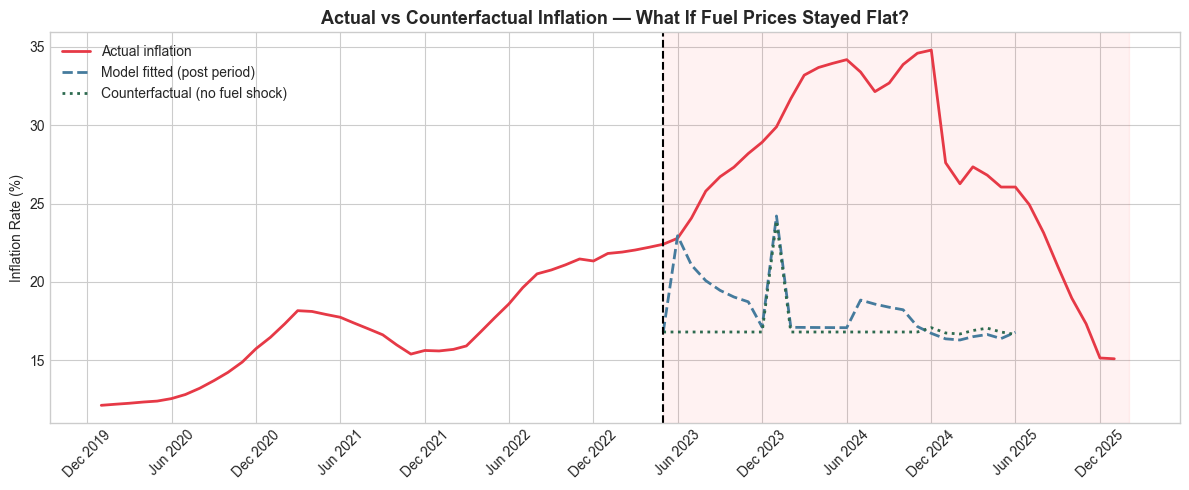

In [9]:
# Fit model on pre period using pct changes
from sklearn.linear_model import LinearRegression

df_pct = df_feat.copy()
df_pct['fuel_pct'] = df_pct['fuel_price_ngn'].pct_change() * 100
df_pct['fx_pct'] = df_pct['usd_ngn'].pct_change() * 100
df_pct = df_pct.dropna(subset=['fuel_pct', 'fx_pct', 'inflation_all_items'])

pre_pct = df_pct[df_pct['post_subsidy_removal'] == 0]
post_pct = df_pct[df_pct['post_subsidy_removal'] == 1]

model_pre = LinearRegression()
model_pre.fit(pre_pct[['fuel_pct', 'fx_pct']], pre_pct['inflation_all_items'])

# Counterfactual: what if fuel prices had stayed flat post-removal?
post_counterfactual = post_pct.copy()
post_counterfactual['fuel_pct'] = 0  # no fuel price change
predicted_no_shock = model_pre.predict(post_counterfactual[['fuel_pct', 'fx_pct']])

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_feat['date'], df_feat['inflation_all_items'], 
        color='#e63946', linewidth=2, label='Actual inflation')
ax.plot(post_pct['date'], model_pre.predict(post_pct[['fuel_pct', 'fx_pct']]),
        color='#457b9d', linewidth=2, linestyle='--', label='Model fitted (post period)')
ax.plot(post_pct['date'], predicted_no_shock,
        color='#2d6a4f', linewidth=2, linestyle=':', label='Counterfactual (no fuel shock)')

ax.axvline(pd.Timestamp('2023-05-01'), color='black', linestyle='--', linewidth=1.5)
ax.axvspan(pd.Timestamp('2023-05-01'), df_feat['date'].max(), alpha=0.05, color='red')

ax.set_title('Actual vs Counterfactual Inflation — What If Fuel Prices Stayed Flat?',
             fontsize=13, fontweight='bold')
ax.set_ylabel('Inflation Rate (%)')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/counterfactual.png', dpi=150)
plt.show()

## Section 3 — Model Comparison

We run four models to see which features consistently matter. We're not 
chasing prediction accuracy here — we're using the models as a lens to 
understand which variables carry the most explanatory weight.

In [10]:
X, y, feature_names = get_model_data(df_feat, target='inflation_all_items')

# Time series split — last 12 months as test
split = len(X) - 12
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

models = train_all_models(X_train, y_train)
results = evaluate_all_models(models, X_test, y_test)

print("=== Model Performance on Test Set (last 12 months) ===")
print(results)
print()
print("Note: Negative R² means the model performs worse than simply")
print("predicting the mean. This is expected — inflation dynamics are")
print("complex and driven by factors beyond fuel prices and exchange rates.")
print("We use these models for feature importance, not prediction.")

=== Model Performance on Test Set (last 12 months) ===
                 R2  RMSE  MAE
random_forest -1.03  5.04 3.92
lasso         -3.20  7.25 6.91
ridge         -3.34  7.37 6.99
linear        -3.44  7.46 7.07

Note: Negative R² means the model performs worse than simply
predicting the mean. This is expected — inflation dynamics are
complex and driven by factors beyond fuel prices and exchange rates.
We use these models for feature importance, not prediction.


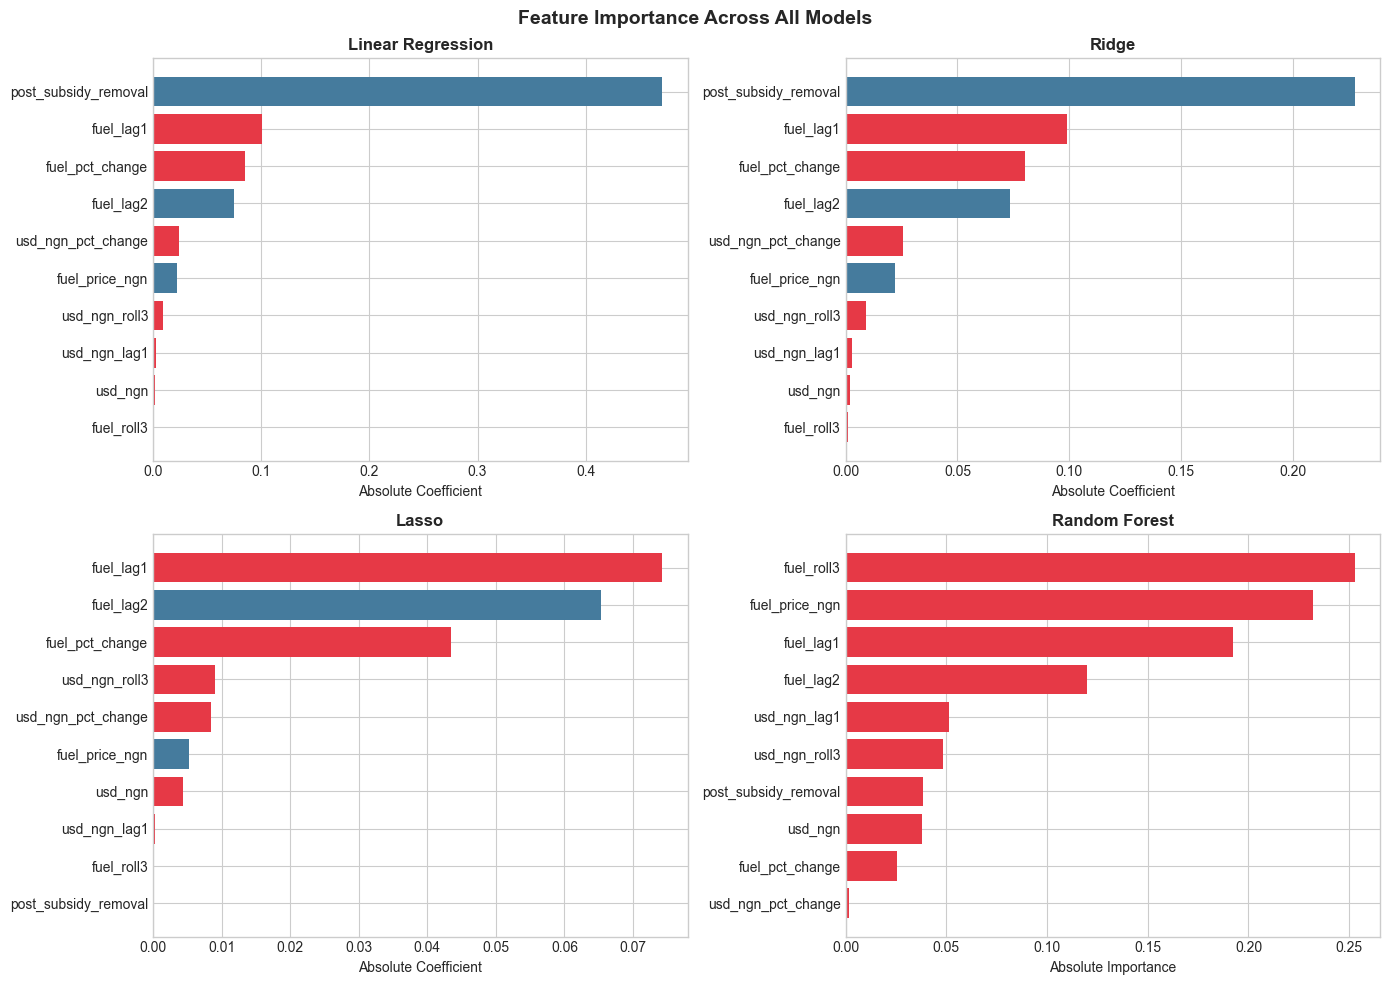

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

model_names = {'linear': 'Linear Regression', 'ridge': 'Ridge', 
               'lasso': 'Lasso', 'random_forest': 'Random Forest'}

for ax, (name, model) in zip(axes, models.items()):
    imp = get_feature_importance(model, feature_names)
    col = 'Importance' if 'Importance' in imp.columns else 'Coefficient'
    
    colors = ['#e63946' if v > 0 else '#457b9d' for v in imp[col]]
    ax.barh(imp['Feature'], imp[col].abs(), color=colors)
    ax.set_title(model_names[name], fontweight='bold')
    ax.set_xlabel('Absolute ' + col)
    ax.invert_yaxis()

plt.suptitle('Feature Importance Across All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=150)
plt.show()

## Section 4 — Key Findings & Limitations

### Findings
1. **Confirmed structural break** — The Chow test (F=44.46, p≈0) formally 
   confirms that the relationship between fuel prices, exchange rates and 
   inflation fundamentally changed at May 2023. This is not just a level 
   shift — the transmission mechanism itself changed.

2. **Scale of the fuel shock** — Fuel prices averaged 7.54% monthly growth 
   post-removal vs 0.57% pre-removal — 13x more volatile. The counterfactual 
   analysis suggests inflation would have remained around 16-17% without the 
   fuel shock, compared to the actual peak of 35%.

3. **Exchange rate as amplifier** — The naira depreciation (from ~₦418 to 
   ~₦1,293 per USD) amplified the shock by making imported goods and fuel 
   inputs more expensive, though its direct month-on-month contribution was 
   smaller than fuel prices.

4. **Models can't predict inflation well** — This is honest and expected. 
   Inflation is driven by expectations, monetary policy, global commodity 
   prices and supply chains — factors not in this dataset. The models are 
   useful for understanding relationships, not forecasting.

### Limitations
- Exchange rate data uses World Bank annual averages expanded to monthly 
  for 2021–2023, which understates intra-year volatility
- Fuel price data relies on interpolation between sparse NBS PMS reports 
  for some months
- Key confounders not in dataset: global oil prices, CBN monetary policy, 
  food supply chain disruptions, pre-existing naira pressure
- 74 months of data is a relatively small sample for time series modelling